# Task1
Create simplified recursive filter and compare its results with 1D Kalman filter

## Data Generation

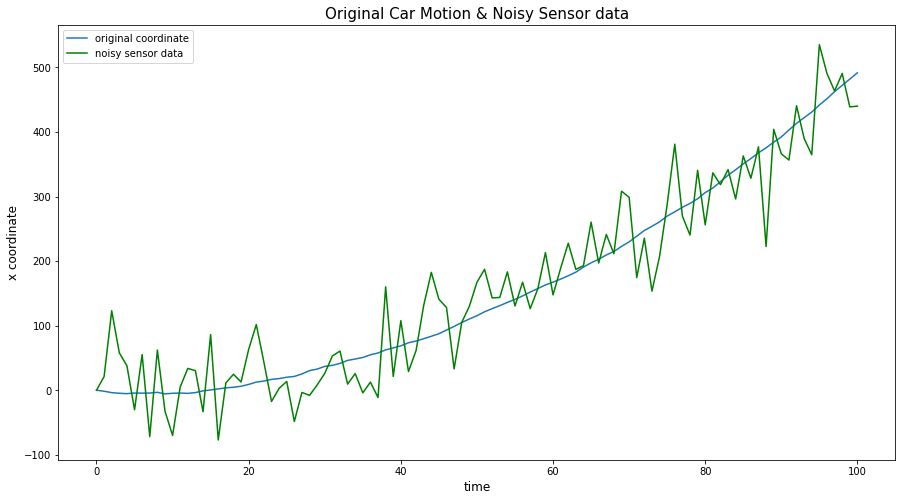

In [88]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,8)


N = 100  # number of samples
time = np.arange(0, N, 1)
muPsi, sigmaPsi = 0, 1     # mean and standard deviation that describe the motion model error
muEta, sigmaEta = 0, 50     # mean and standard deviation that describe the sensor error
errorPsi = np.random.normal(muPsi, sigmaPsi, 100)   # pdf of the motion model error
errorEta = np.random.normal(muEta, sigmaEta, 100)   # pdf of the sensor error


a = 0.1  # acceleration
x = np.zeros(N+1)
z = np.zeros(N+1)

time = np.arange(0, N+1, 1)

for t in range(0, N):
    x[t+1] = x[t] + a * t + np.random.normal(muPsi, sigmaPsi, 1)
    z[t+1] = x[t+1] + np.random.normal(muEta, sigmaEta, 1)

plt.title('Original Car Motion & Noisy Sensor data',fontsize=15)
plt.xlabel('time',fontsize=12)
plt.ylabel('x coordinate',fontsize=12)    
plt.plot(time, x, label='original coordinate')  
plt.plot(time, z, 'g', label='noisy sensor data')  
plt.legend()


## Linear Kalman Filter 

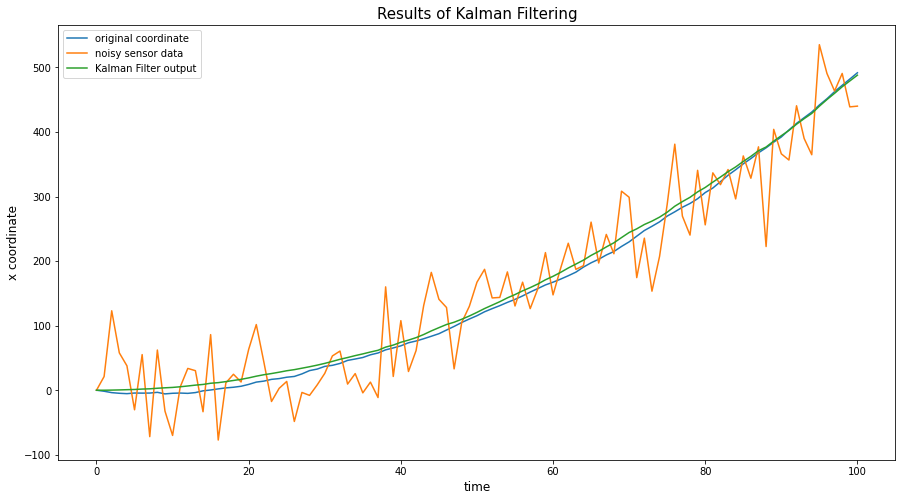

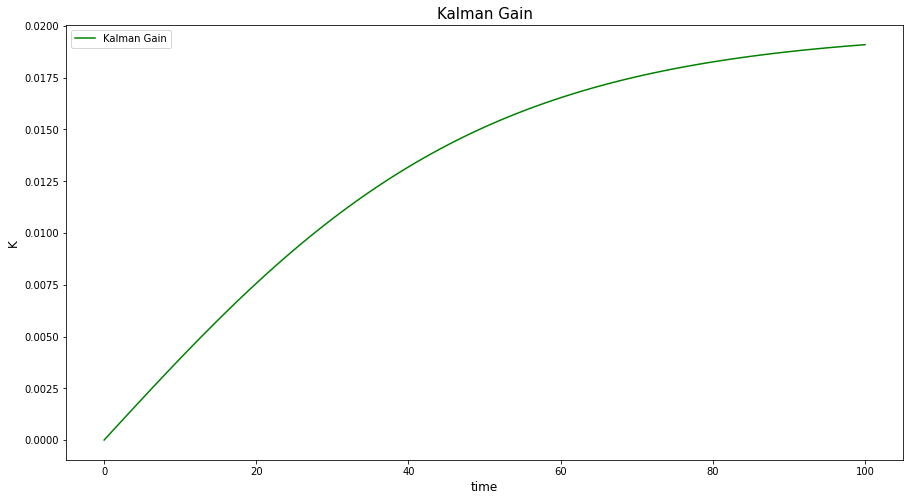

In [89]:
eOpt = np.zeros(N+1)
K    = np.zeros(N+1)
xOpt = np.zeros(N+1)

for t in range(0, N):
    eOpt[t+1] = np.sqrt((sigmaEta**2) * (eOpt[t]**2 + sigmaPsi**2)/(sigmaEta**2 + eOpt[t]**2 + sigmaPsi**2))
    K[t+1] = (eOpt[t+1]**2)/sigmaEta**2
    xOpt[t+1] = (xOpt[t]+a*t) * (1-K[t+1]) + K[t+1]*z[t+1]


plt.title('Results of Kalman Filtering',fontsize=15)
plt.xlabel('time',fontsize=12)
plt.ylabel('x coordinate',fontsize=12)
plt.plot(time, x, label='original coordinate')  
plt.plot(time, z, label='noisy sensor data')  
plt.plot(time, xOpt, label='Kalman Filter output') 
plt.legend()
plt.show()

plt.title('Kalman Gain',fontsize=15)
plt.xlabel('time',fontsize=12)
plt.ylabel('K',fontsize=12)
plt.plot(time, K, 'g', label='Kalman Gain') 
plt.legend()

## Recursive Filter

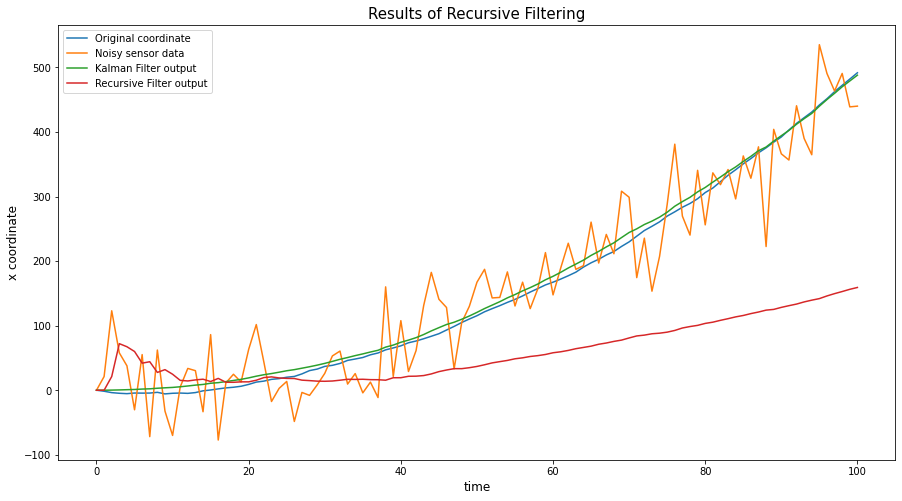

In [90]:
Rec_f=np.zeros(N+1)

Rec_f[0]=z[0]

for t in range(1,N):
  Rec_f[t+1]=((t-1)/t) * Rec_f[t]+ (1/t) * z[t]


plt.title('Results of Recursive Filtering',fontsize=15)
plt.xlabel('time',fontsize=12)
plt.ylabel('x coordinate',fontsize=12)
plt.plot(time, x, label='Original coordinate')  
plt.plot(time, z, label='Noisy sensor data')  
plt.plot(time, xOpt, label='Kalman Filter output') 
plt.plot(time, Rec_f, label='Recursive Filter output') 
plt.legend()
plt.show()

We can see that Kalamn filter is doing a much better job estimating the state when compared to the simple recursive filer.

# Task2

The task is to predict the traveled distance based on the linear accelerometer measurement.
Update the predicted value using the distance measurements of the GPS sensor.

Apply Kalman filter to predict the traveled distance and plot the graphs of the measured distance
(in meters) and the predicted distance (in meters)

In [91]:
#!pip install mpu

In [92]:
import pandas as pd
from math import *
from mpu import haversine_distance

## Kalman Class Implementation

In [93]:
# Kalman Class

class KalmanFilter(object):
    def __init__(self, dt, std_acc, std_meas):
        self.dt = dt
        self.std_acc = std_acc
        self.A = np.matrix([[1, self.dt],
                            [0, 1]])
        self.B = np.matrix([[(self.dt**2)/2], [self.dt]]) 
        self.H = np.matrix([[1,0]])
        self.Q = np.matrix([[(self.dt**4)/4, (self.dt**3)/2],
                            [(self.dt**3)/2, self.dt**2]]) * self.std_acc**2
        self.R = std_meas**2
        self.P = np.eye(self.A.shape[1])
        self.x = np.matrix([[0],[0]])

    def predict(self,u):
      
        # Update time state
        self.x = np.dot(self.A, self.x) + np.dot(self.B, u)

        # Calculate error covariance
        
        self.P = np.dot(np.dot(self.A, self.P), self.A.T) + self.Q
        return self.x

    def update(self, z):
        
        
        S = np.dot(self.H, np.dot(self.P, self.H.T)) + self.R

        # Calculate the Kalman Gain
        
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))  

        self.x = np.round(self.x + np.dot(K, (z - np.dot(self.H, self.x))))  

        I = np.eye(self.H.shape[1])
        self.P = (I - (K * self.H)) * self.P 
        return self.x


## Data Calculation 

Index(['time', 'ax', 'ay', 'az', 'Latitude', 'Longitude', 'Speed (m/s)'], dtype='object')


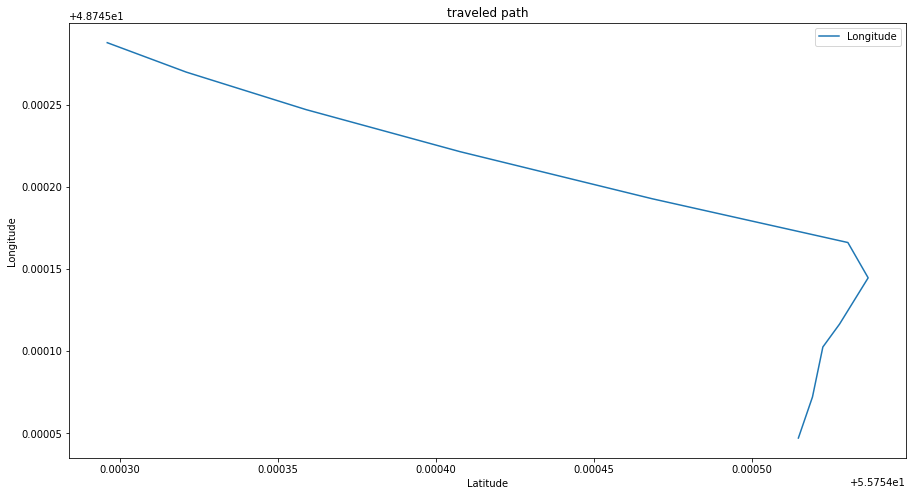

In [102]:
# loading data with pandas easy and fast
Data = pd.read_csv('data2.csv')
Data=Data.iloc[1200: , :-1]
Data.head(10)

print(Data.columns)

#Extract useful data from the df
ax=np.array(Data['ax'])
ay=np.array(Data['ay'])
az=np.array(Data['az'])

Latitude=np.array(Data['Latitude'])
Longitude=np.array(Data['Longitude'])
time=np.array(Data['time'])




#plot the path
Data.plot(x='Latitude', y='Longitude')
plt.title('traveled path')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()




In [103]:

#calculate acceleration
acc = [sqrt(ax[i]**2+ay[i]**2+az[i]**2) for i in range(len(ax))] 

#calculate time step
T = [time[i+1]-time[i] for i in range(len(time)-1)]
dt=np.mean(T)


# calculate displacements from GPS
displacement=[]
for i in range(len(Latitude)-1):
    d=haversine_distance([Latitude[i],Longitude[i]],[Latitude[i+1],Longitude[i+1]])
    displacement.append(d)

# calculate distance using GPS
gps_distance=[0]
for i in range(len(displacement)):
  gps_distance.append(gps_distance[i]+displacement[i])



# std for measurements and inputs    
std_acc=np.std(acc)
std_dis = np.std(displacement)


## Estimation

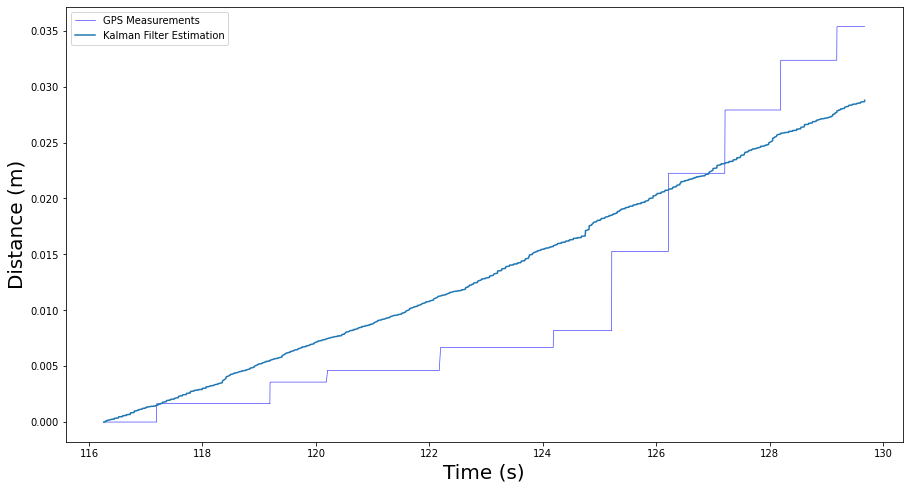

In [101]:
# create KalmanFilter instance
kf = KalmanFilter(dt,std_acc, std_dis)
predictions = []
measurements = []
est=[]

for i in range(len(displacement)):
      z=displacement[i]
      measurements.append(z)
      predictions.append(kf.predict(acc[i])[0])
      est.append(kf.update(z))

predictions=(np.squeeze(predictions))

estimated_distance=[0]
for i in range(len(predictions)):
  estimated_distance.append((estimated_distance[i]+0.14*predictions[i]))


plt.plot(time, gps_distance, label='GPS Measurements', color='b',linewidth=0.5)
plt.plot(time, np.array(estimated_distance), label='Kalman Filter Estimation')
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel('Distance (m)', fontsize=20)
plt.legend()
plt.show()

Unfortunatly the data was highly corrupted so I had to cut a big portion of it. That left me with very little number of samples as you can see above, which affected the work Kalman Filter. But as you can see the implementation is correct and it gives acceptable results.


Data is available on [GitHub](https://github.com/ahmad12hamdan99/SPA.git)